# CSE 416 Homework 6: ML Kaggle Exercise
Team Name: BACmono \
Team Member: Bob Lin, Angela Zhao, Chris Chen


---




## Import Packages

In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

## Read Dataset and Manipulate with Null Values

In [2]:
edx_train_data = pd.read_csv('edx_train.csv')
edx_test_data = pd.read_csv('edx_test.csv')

Check the count of null values in each column

In [3]:
edx_train_data.isna().sum()

course_id               0
userid_DI               0
registered              0
viewed                  0
explored                0
certified               0
final_cc_cname_DI       0
LoE_DI                966
YoB                   914
gender                775
grade                 370
start_time_DI           0
last_event_DI        1508
nevents              1639
ndays_act            1639
nplay_video          6747
nchapters            2563
nforum_posts            0
dtype: int64

Note that there are many columns with null values, and each column has different type and meaning, so we cannot simply delete rows with the null. Therefore, we analyzed the property and real-life implication of each column, and then implement corresponding manipulations.

**1. Fill in the null values of numerical variables** \\
For `nevent`, `ndays_act`, `nplay_video`, and `nchapters`, we fill the null values with 0 because the description file says that blank `nevent` if zero no interaction beyond registration, and we assumed the rest of variables beginning with `n` have the same setting.

In [4]:
for value in ['nevents', 'ndays_act', 'nplay_video', 'nchapters']:
  edx_train_data[value] = edx_train_data[value].fillna(0)

**2. Fill in the null values of categorical variables** \\
`gender` and `LoE_DI` are categorical variables. According to the spec, `gender` has three values--'male', 'female', and 'other'. Since all the non-null data are either 'male' or 'female', we fill in the null with 'other' ('o' as the value). Then `LoE_DI` is also a categorical variable, but all the possible values appear in the spec appears in this table, so we need to create an 'other' for the null values. But later we will remove this column after we get dummies, so that this value will not have any influence on the prediction result since it's not something we should see according to the spec.

In [5]:
for value2 in ['LoE_DI', 'gender']: 
  edx_train_data[value2] = edx_train_data[value2].fillna('o')

average_yob = math.floor(edx_train_data['YoB'].mean()) * 1.0
edx_train_data['YoB'] = edx_train_data['YoB'].fillna(average_yob)

**3. Fill in the null values of should-be numerical variables**  \\
Because there are some blank spaces in `grade`, all values of this variable are string rather than numeric. Therefore, we firstly remove all empty spaces in `grade` and then turn them into numeric variables such that `get_dummies()` won't treat them as categorical variables and put them into separate columns. We will fill in the null values with mean grade.

In [6]:
edx_train_data['grade'] = edx_train_data['grade'].str.strip()
data = edx_train_data['grade'].tolist()
sum = 0.0
count = len(edx_train_data['grade'])
minus = 0
for value3 in data: 
  if isinstance(value3, str) and len(value3.strip()) != 0:
    sum = sum + float(value3)
  else: 
    minus = minus + 1
average_grade = sum/(count - minus)
edx_train_data['grade'] = pd.to_numeric(edx_train_data['grade'])
edx_train_data['grade'] = edx_train_data['grade'].fillna(average_grade)

**4. Fill in the null values of date variables** \\
It is hard to directly analyze the start date and end date, but the duration is more useful for analysis. After we checked the null values for each columns, we can see that start dates are all filled whereas end dates are not. So, if both start and end dates exist, `duration` is just the difference between the two; otherwise, it is filled by the average value.

In [7]:
sum = 0
count = 0
day_list = []
for value4 in range(edx_train_data.shape[0]):
  d1 = edx_train_data['start_time_DI'][value4]
  d2 = edx_train_data['last_event_DI'][value4]
  if isinstance(d2, str):
    d1 = datetime.strptime(d1, '%m/%d/%y')
    d2 = datetime.strptime(d2, '%m/%d/%y')
    day = abs(d1 - d2).days
    sum += day
    count = count + 1
    day_list.append(day)
  else:
    day_list.append(np.nan)
average_duration = sum / count

edx_train_data['duration'] = day_list
edx_train_data['duration'] = edx_train_data['duration'].fillna(average_duration)
edx_train_data = edx_train_data.drop(['start_time_DI', 'last_event_DI'], axis=1)

## Feature Selection
Since `certified` is our target of prediction, and `userid_DI` is unique to every user and doesn't have analysis value, we removed these two variables from the features.

In [8]:
features = edx_train_data.columns.to_list()
if 'certified' in features and 'userid_DI' in features:
  features.remove('certified')
  features.remove('userid_DI')
  target = 'certified'
  edx_train_y = edx_train_data[target]

edx_train_data = edx_train_data[features]
features

['course_id',
 'registered',
 'viewed',
 'explored',
 'final_cc_cname_DI',
 'LoE_DI',
 'YoB',
 'gender',
 'grade',
 'nevents',
 'ndays_act',
 'nplay_video',
 'nchapters',
 'nforum_posts',
 'duration']

To make sure categorical variables are trained in classification models, we turn them into numerical variables using `get_dummies()`.

In [9]:
edx_train_data = pd.get_dummies(edx_train_data)
features = list(edx_train_data.columns)

In [10]:
features.remove('LoE_DI_o')
features

['registered',
 'viewed',
 'explored',
 'YoB',
 'grade',
 'nevents',
 'ndays_act',
 'nplay_video',
 'nchapters',
 'nforum_posts',
 'duration',
 'course_id_HarvardX/CB22x/2013_Spring',
 'course_id_HarvardX/CS50x/2012',
 'course_id_HarvardX/ER22x/2013_Spring',
 'course_id_HarvardX/PH207x/2012_Fall',
 'course_id_HarvardX/PH278x/2013_Spring',
 'final_cc_cname_DI_Australia',
 'final_cc_cname_DI_Bangladesh',
 'final_cc_cname_DI_Brazil',
 'final_cc_cname_DI_Canada',
 'final_cc_cname_DI_China',
 'final_cc_cname_DI_Colombia',
 'final_cc_cname_DI_Egypt',
 'final_cc_cname_DI_France',
 'final_cc_cname_DI_Germany',
 'final_cc_cname_DI_Greece',
 'final_cc_cname_DI_India',
 'final_cc_cname_DI_Indonesia',
 'final_cc_cname_DI_Japan',
 'final_cc_cname_DI_Mexico',
 'final_cc_cname_DI_Morocco',
 'final_cc_cname_DI_Nigeria',
 'final_cc_cname_DI_Other Africa',
 'final_cc_cname_DI_Other East Asia',
 'final_cc_cname_DI_Other Europe',
 'final_cc_cname_DI_Other Middle East/Central Asia',
 'final_cc_cname_DI_Oth

Split the training and validation set with a proportion of 80:20 with random state of 1.

In [11]:
X = edx_train_data
y = edx_train_y
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)

In class, we've discussed that Lasso regression is best used for feature selection. We trained several Lasso models with different `lambda` and chose the one with the least validation error. At last, we implemented the Lasso model with lambda=0.000001 and created a dataframe with feature and its coefficient learned from Lasso for further analysis.

In [12]:
np.logspace(-15,5,21,base=10)

array([1.e-15, 1.e-14, 1.e-13, 1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08,
       1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00,
       1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])

In [13]:
lamb = np.logspace(-15,5,21,base=10)
lasso_data = []
for i in range(len(lamb)):
    l1_model = Lasso(alpha=lamb[i], random_state=0)
    l1_model.fit(X_train, y_train)
    y_pred = l1_model.predict(X_train)
    train_rmse = mean_squared_error(y_train, y_pred, squared=False)
    y_pred = l1_model.predict(X_valid)
    validation_rmse = mean_squared_error(y_valid, y_pred, squared=False)
    lasso_data.append({
        'l1_penalty': lamb[i],
        'model': l1_model,
        'train_rmse': train_rmse,
        'validation_rmse': validation_rmse
    })
lasso_data = pd.DataFrame(lasso_data)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.08185273525001, tolerance: 0.17318538395660868
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.992234465035516, tolerance: 0.17318538395660868
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.971930087144898, tolerance: 0.17318538395660868
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: Convergenc

In [14]:
lasso_data

,l1_penalty,model,train_rmse,validation_rmse
0,1.000000e-15,"Lasso(alpha=1e-15, random_state=0)",0.121752,0.115813
1,1.000000e-14,"Lasso(alpha=1e-14, random_state=0)",0.121752,0.115813
2,1.000000e-13,"Lasso(alpha=1e-13, random_state=0)",0.121752,0.115813
3,1.000000e-12,"Lasso(alpha=1e-12, random_state=0)",0.121752,0.115813
4,1.000000e-11,"Lasso(alpha=1e-11, random_state=0)",0.121752,0.115813
5,1.000000e-10,"Lasso(alpha=1e-10, random_state=0)",0.121752,0.115813
6,1.000000e-09,"Lasso(alpha=1e-09, random_state=0)",0.121752,0.115813
7,1.000000e-08,"Lasso(alpha=1e-08, random_state=0)",0.121752,0.115813
8,1.000000e-07,"Lasso(alpha=1e-07, random_state=0)",0.121752,0.115813
9,1.000000e-06,"Lasso(alpha=1e-06, random_state=0)",0.121752,0.115814


In [15]:
def df_coefficients(model, features):
    """
    This function takes in a model column and a features column. 
    And constructs a dataframe with feature and its coefficient.
    """
    feats = list(zip(features, model.coef_))
    coef_df = pd.DataFrame(feats)
    coef_df = coef_df.rename(columns={0:'feature',1:'coefficient'})
    return coef_df
    
index = 9
l1 = lasso_data.loc[index]
zero_coef = abs(l1['model'].coef_) > 10 ** -2 * 4

coef_df = df_coefficients(l1['model'], features)


We found all features with nonzero coefficient and decided to use the most important 6 features to make predictions: `explored`, `grade`, `course_id_HarvardX/PH207x/2012_Fall`, `course_id_HarvardX/PH278x/2013_Spring`, `final_cc_cname_DI_Greece`, and `final_cc_cname_DI_Other Oceania`.

In [16]:
new_features = []
for num in range(len(zero_coef)):
  if zero_coef[num] == True:
    new_features.append(features[num])

new_feat_df = coef_df.loc[coef_df['feature'].isin(new_features)]
new_feat_df = new_feat_df.reset_index(drop=True)
important_features_index = new_feat_df['coefficient'].nlargest(5).index
important_features = new_feat_df.iloc[important_features_index]

print('Number of selected features:', len(new_feat_df))
new_feat_df

Number of selected features: 6


,feature,coefficient
0,explored,0.085004
1,grade,0.882290
2,course_id_HarvardX/PH207x/2012_Fall,-0.040044
3,course_id_HarvardX/PH278x/2013_Spring,0.061228
4,final_cc_cname_DI_Greece,0.045714
5,final_cc_cname_DI_Other Oceania,-0.046482


## Classifer 1: Majority Classifer

We first create a majority classier and compute its accuracy as the baseline. 

In [17]:
sum = edx_train_y.sum()/edx_train_data.shape[0]
major_label = 1
if sum < 0.5:
  major_label = 0
true_pred = y_valid.value_counts()[major_label]
majority_classifier_validation_accuracy = true_pred / len(X_valid)

The accuracy is 0.5679223744292238, approximately 57%.

## Classifier 2: Adaboost Classifier

Then we create an adaboost classifier and compute its accuracy. We expect it to be pretty high.

In [18]:
adaboost_model = AdaBoostClassifier(n_estimators=100, random_state=0)
adaboost_model.fit(X_train[new_features],y_train)
y_pred = adaboost_model.predict(X_valid[new_features])
training_score = adaboost_model.score(X_train[new_features],y_train)
a_validation_score = adaboost_model.score(X_valid[new_features],y_valid)

print('Adaboost classifier training score:',training_score)
print('Adaboost classifier validation score:',a_validation_score)

Adaboost classifier training score: 0.9995717956037682
Adaboost classifier validation score: 1.0


Good lord the score is 1! But can we improve the performance by using `GridSearchCV`? 

In [19]:
hyperparameters = {
  'n_estimators': [10,25,50,100,150,200],
  'learning_rate': np.logspace(-4,0,5,base=10),
  'algorithm': ['SAMME','SAMME.R']
}
search = GridSearchCV(estimator=AdaBoostClassifier(),param_grid=hyperparameters, \
                      cv=6,return_train_score=True)
search.fit(X_train[new_features],y_train)

print(search.best_params_)

{'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 25}


In [20]:
adaboost_model = AdaBoostClassifier(n_estimators=25, random_state=0)
adaboost_model.fit(X_train[new_features],y_train)
y_pred = adaboost_model.predict(X_valid[new_features])
training_score = adaboost_model.score(X_train[new_features],y_train)
a_validation_score = adaboost_model.score(X_valid[new_features],y_valid)

print('Adaboost classifier training score:',training_score)
print('Adaboost classifier validation score:',a_validation_score)

Adaboost classifier training score: 0.9995717956037682
Adaboost classifier validation score: 1.0


No obvious improvement. Should I be sad?

## Classifier 3: K-Neareast Neighbor Regression

We will then create a k-NN classifier to see how it performs. We also expect it to be high.

In [21]:
knn15_model = KNeighborsClassifier(n_neighbors = 15, weights = 'distance')
knn15_model.fit(X_train[new_features], y_train)
y_pred_knn = knn15_model.predict(X_valid[new_features])
knn15_train_score = knn15_model.score(X_train[new_features], y_train)
knn15_validation_score = knn15_model.score(X_valid[new_features], y_valid)

print('15-NN classifier training score:', knn15_train_score)
print('15-NN classifier validation score:', knn15_validation_score)

15-NN classifier training score: 0.9997145304025121
15-NN classifier validation score: 1.0


Oh its score is also 1! Let's try to search for a better parameter.

In [22]:
knn_hyperparameters = {
  'n_neighbors': np.linspace(1, 30, num = 30).astype(int),
}
knn_search = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = knn_hyperparameters, \
                      cv = 10, return_train_score = True)
knn_search.fit(X_train[new_features], y_train)
print(knn_search.best_params_)

{'n_neighbors': 4}


It turns out the best k is k = 4.

In [23]:
knn4_model = KNeighborsClassifier(n_neighbors = 4, weights = 'distance')
knn4_model.fit(X_train[new_features], y_train)
y_pred_knn = knn4_model.predict(X_valid[new_features])
knn4_train_score = knn4_model.score(X_train[new_features], y_train)
knn4_validation_score = knn4_model.score(X_valid[new_features], y_valid)

print('4-NN classifier training score:', knn4_train_score)
print('4-NN classifier validation score:', knn4_validation_score)

4-NN classifier training score: 0.9997145304025121
4-NN classifier validation score: 1.0


No obvious improvement. I guess I'm happy though.

## Classifier 4: Logistic Regression

Lastly, we will try a logistic model.

In [24]:
lgr_model = LogisticRegression(penalty='l2', random_state=1)
lgr_model.fit(X_train[new_features],y_train)
y_pred = lgr_model.predict(X_valid[new_features])
training_score = lgr_model.score(X_train[new_features],y_train)
l_validation_score = lgr_model.score(X_valid[new_features],y_valid)

print('Logistic classifier training score:',training_score)
print('Logistic classifier validation score:',l_validation_score)

Logistic classifier training score: 0.9950042820439623
Logistic classifier validation score: 0.9948630136986302


Search for better parameters and re-run.

In [25]:
hyperparameters = {
  'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}
search = GridSearchCV(estimator=LogisticRegression(),param_grid=hyperparameters, \
                      cv=6,return_train_score=True)
search.fit(X_train[new_features],y_train)

print(search.best_params_)

{'solver': 'newton-cg'}


In [26]:
lgr_model = LogisticRegression(penalty='l2', solver='newton-cg', random_state=1)
lgr_model.fit(X_train[new_features],y_train)
y_pred = lgr_model.predict(X_valid[new_features])
training_score = lgr_model.score(X_train[new_features],y_train)
l_validation_score = lgr_model.score(X_valid[new_features],y_valid)

print('Logistic classifier training score:',training_score)
print('Logistic classifier validation score:',l_validation_score)

Logistic classifier training score: 0.9950042820439623
Logistic classifier validation score: 0.9948630136986302


Ok, no obvious improvement, and the score is lower than adaboost and k-NN. Bye logistic!

## Visualization

We will show graphically how good the models perform.

<BarContainer object of 4 artists>

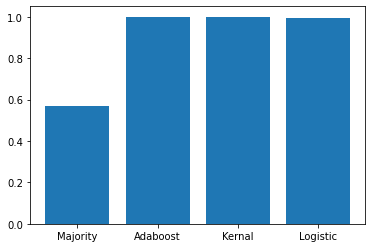

In [27]:
x = ['Majority', 'Adaboost', 'Kernal', 'Logistic']
y = [majority_classifier_validation_accuracy, a_validation_score, knn4_validation_score, l_validation_score]
plt.bar(x,y)

From the diagram above, all of AdaBoost, k-NN, and Logistic models work very well--over 99 percent accuracy. Among these three models, AdaBoost and k-NN has the highest validation accuracy, which is 1; and since k-NN is the most recently learned model, we will choose this as our main model.

We tried to improve our prediction by using `GridSearchCV()`, but no obvious improvement is made. I guess you cannot be more correct than all correct, right?

## Dealing with Test data

We need to transform test data as well.

In [28]:
# Set nan to 0
for value in ['nevents', 'ndays_act', 'nplay_video', 'nchapters']: # set nan to 0
  edx_test_data[value] = edx_test_data[value].fillna(0)

# Set nan to majority value
for value2 in ['LoE_DI', 'gender']: 
  edx_test_data[value2] = edx_test_data[value2].fillna('o')

average_yob = math.floor(edx_test_data['YoB'].mean()) * 1.0
edx_test_data['YoB'] = edx_test_data['YoB'].fillna(average_yob)

# Set nan to the mean value
edx_test_data['grade'] = edx_test_data['grade'].str.strip()
data = edx_test_data['grade'].tolist()
sum = 0.0
count = len(edx_test_data['grade'])
minus = 0
for value3 in data: 
  if isinstance(value3, str) and len(value3.strip()) != 0:
    sum = sum + float(value3)
  else: 
    minus = minus + 1
average_grade = sum/(count - minus)
edx_test_data['grade'] = pd.to_numeric(edx_test_data['grade'])
edx_test_data['grade'] = edx_test_data['grade'].fillna(average_grade)

edx_train_data['grade'] = edx_train_data['grade'].fillna(average_grade)

# Create a new column of duration and set nan to the mean value
sum = 0
count = 0
day_list = []
for value4 in range(edx_test_data.shape[0]):
  d1 = edx_test_data['start_time_DI'][value4]
  d2 = edx_test_data['last_event_DI'][value4]
  if isinstance(d2, str):
    d1 = datetime.strptime(d1, '%m/%d/%y')
    d2 = datetime.strptime(d2, '%m/%d/%y')
    day = abs(d1 - d2).days
    sum += day
    count = count + 1
    day_list.append(day)
  else:
    day_list.append(np.nan)
average_duration = sum / count

edx_test_data['duration'] = day_list
edx_test_data['duration'] = edx_test_data['duration'].fillna(average_duration)
edx_test_data = edx_test_data.drop(['start_time_DI', 'last_event_DI'], axis=1)

In [29]:
user_id = edx_test_data['userid_DI']
edx_test_data = pd.get_dummies(edx_test_data)
edx_test_data = edx_test_data[new_features]

## Test Prediction

In [30]:
edx_test_data['certified'] = knn4_model.predict(edx_test_data)
edx_test_data['userid_DI'] = user_id
test_data = edx_test_data[['userid_DI', 'certified']]
edx_test_data = edx_test_data[new_features]
test_data.head(5)

,userid_DI,certified
0,MHxPC130476531,1
1,MHxPC130559898,0
2,MHxPC130552712,1
3,MHxPC130394971,1
4,MHxPC130191077,1


In [31]:
test_data.to_csv('submission.csv',index=False)

## Ethical Analysis

If the model is used to maximize profit, then it means this model aims to maximize 1. the money that can earn from each student and 2. the number of students. Then this model will not be fair—people from high income backgrounds and people from backgrounds that value education / certificates very much will be over-represented. On the other hand, people from lower income backgrounds will be under-represented. In short, this program will correctly identify the student group that pays the most and has the most numbers, and then the rest will miss the opportunity. Accuracy will be high, but fairness will be low. Imagine people live in rich urban areas and people live in poor rural areas—people in rich urban areas will get all the opportunities and people in poor rural areas will get little or none. This is not fair. 

We’ve talked about tradeoff between accuracy and fairness in week 4, this is the same thing. It’s just that in this case, higher accuracy means more profit and vice versa, so there’s a tradeoff between profit and fairness. We should think of the opportunities the lower income groups could get before acting on this plan.
